In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [4]:
import os

def get_folder_structure(directory):
    folder_structure = {}

    for root, dirs, files in os.walk(directory):
        folder_name = os.path.basename(root)
        file_list = [f for f in files if not f.startswith('.')]  # Exclude hidden files
        folder_structure[folder_name] = file_list

    return folder_structure

# Example usage:
directory_path = "/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl"
folder_structure = get_folder_structure(directory_path)
print(folder_structure)


{'experiments_tfcl_sdl': ['results_hyperparametertuning.zip', 'experiment_tfcl_sdl.py', 'experiment_tfcl_sdl.ipynb'], 'configs_done': ['config_DomesticDeclarations_0.5.json', 'config18.json', 'config_RequestForPayment_new_0.json', 'config_Hospital+BPI12_1000.json', 'config22.json', 'config14.json', 'config6.json', 'config_DomesticDeclarations_0.json', 'config_DomesticDeclarations_1.json', 'config7.json', 'config15.json', 'config_IOR7500.json', 'config23.json', 'config_RequestForPayment_new_1.json', 'config_RIO5000.json', 'config_OIR2500.json', 'config19.json', 'config_PermitLog_0.5.json', 'config12.json', 'config_IRO7500.json', 'config_PermitLog_1.json', 'config28.json', 'config_OIR5000.json', 'config24.json', 'config_PrepaidTravelCost_new_1.json', 'config_PrepaidTravelCost_new_0.json', 'config_BPIC17.json', 'config25.json', 'config_ORI5000.json', 'config_ROI5000.json', 'config29.json', 'config_PermitLog_0.json', 'config1.json', 'config13.json', 'config_Hospital+BPI12.json', 'config_In

### find drift locations for synthetic datasets

In [5]:
import pandas as pd

def get_drift_locations(file_path):
    # Extracting data name from the file path
    data_name = file_path.split('/')[-1].replace('.csv', '')

    # Reading the CSV file
    df = pd.read_csv(file_path)

    # Finding the unique cases and calculating the drift interval
    num_unique_cases = df['case'].nunique()
    drift_interval = num_unique_cases // 10

    # Finding the drift locations based on the drift interval
    drift_locations = []
    case_count = 0
    previous_case = None
    for index, row in df.iterrows():
        current_case = row['case']
        if current_case != previous_case:
            case_count += 1
            if case_count % drift_interval == 0:
                drift_locations.append(index)
        previous_case = current_case

    return data_name, drift_locations

In [6]:
def get_accuracy_after_first_drift(experiment_path, first_drift):
    prediction_results = pd.read_csv(os.path.join(experiment_path, "prediction_results.csv"))
    actual_labels_np = np.array(prediction_results['actual_labels'])
    prediction_labels_np = np.array(prediction_results['prediction_labels'])

    # Create the modified dictionary
    prediction_results = np.concatenate((actual_labels_np.reshape(-1, 1), prediction_labels_np.reshape(-1, 1)), axis=1)
    # prediction_results = np.concatenate((actual_labels_np.reshape(-1, 1), prediction_labels_np.reshape(-1, 1)), axis=1)
    total_accuracy = (prediction_results[:, 0] == prediction_results[:, 1]).sum() / prediction_results.shape[0]
    total_accuracy_after_first_drift = (prediction_results[first_drift:, 0] == prediction_results[first_drift:, 1]).sum() / prediction_results[first_drift:, :].shape[0]
    # print("Total accuracy is {}".format(total_accuracy))
    return total_accuracy, total_accuracy_after_first_drift
    

In [7]:
# def get_dataset_name_and_ratio_and_accuracy_and_runningtime(experiment_path, first_drift):
#     with open(os.path.join(experiment_path, 'evaluation_res.json'), 'r') as file:
#         data = json.load(file)
#         ratio = data['ratio']  # This assumes that 'ratio' is a key in your JSON. Modify as needed.
#         running_time = data['running_time']
#         # total_accuracy = data['total_accuracy']
#         total_accuracy, total_accuracy_after_first_drift = get_accuracy_after_first_drift(experiment_path,first_drift)
#     dataset_name = experiment_path.split("/")[-1].split("_")[0]
#     return dataset_name, ratio, total_accuracy, total_accuracy_after_first_drift, running_time

def get_dataset_name_and_ratio_and_accuracy_and_runningtime(experiment_path, first_drift=None):
    with open(os.path.join(experiment_path, 'evaluation_res.json'), 'r') as file:
        data = json.load(file)
        ratio = data['ratio']  # This assumes that 'ratio' is a key in your JSON. Modify as needed.
        running_time = data['running_time']
        
        # Check if first_drift is provided
        if first_drift:
            total_accuracy, total_accuracy_after_first_drift = get_accuracy_after_first_drift(experiment_path, first_drift)
        else:
            # Modify this part to compute total_accuracy and total_accuracy_after_first_drift when first_drift is not provided
            total_accuracy = data['total_accuracy']  # Assuming 'total_accuracy' is available in the JSON
            total_accuracy_after_first_drift = total_accuracy  # This is just a placeholder. Modify as needed.

    dataset_name = experiment_path.split("/")[-1].split("_")[0]
    return dataset_name, ratio, total_accuracy, total_accuracy_after_first_drift, running_time

def compute_batch_fixed_size_accuracy(prediction_results,fixed_size):
    # Convert the lists to numpy arrays
    actual_labels_np = np.array(prediction_results['actual_labels'])
    prediction_labels_np = np.array(prediction_results['prediction_labels'])

    # Create the modified dictionary
    prediction_results = np.concatenate((actual_labels_np.reshape(-1, 1), prediction_labels_np.reshape(-1, 1)), axis=1)
    numEvents = prediction_results.shape[0]
    numBatches = int(numEvents/fixed_size)
    #print("Num batches is {}".format(numBatches))
    batch_accuracy = []
    for i in range(numBatches):
        batch_accuracy.append(round(np.sum(prediction_results[i*fixed_size:(i+1)*fixed_size,0]==prediction_results[i*fixed_size:(i+1)*fixed_size,1])/fixed_size, 4))
    #total_accuracy = (prediction_results[:, 0] == prediction_results[:, 1]).sum() / prediction_results.shape[0]
    return batch_accuracy#, total_accuracy

### collect results for visualization BPIC2020

In [8]:
def get_first_drift_realdata(dataName):
    if dataName == "DomesticDeclarations":
        start_drift = 9878
        end_drift = 14501
        first_occurrence_ratio = 17.5
        old_concept_show_again = first_occurrence_ratio + 0.5*(100-first_occurrence_ratio)
    elif dataName == 'InternationalDeclarations':
        start_drift = 12467
        end_drift = 17361
        first_occurrence_ratio = 17.2
    elif dataName == 'PermitLog':
        start_drift = 13677
        end_drift = 18909
        first_occurrence_ratio = 15.7
    elif dataName == 'PrepaidTravelCost':
        start_drift = 2367
        end_drift = 4473
        first_occurrence_ratio = 12.9
    elif dataName == 'RequestForPayment':
        start_drift = 4913
        end_drift = 8298
        first_occurrence_ratio = 13.3
    old_concept_show_again = first_occurrence_ratio + 0.5*(100-first_occurrence_ratio)
    return start_drift, end_drift, old_concept_show_again
    # elif dataName == 'Road_Traffic_Fine_Management_Process':
# Draw vertical red line at x-axis = 15923
    plt.axvline(x=12467, color='r', linestyle='--', label='start drift')
    plt.axvline(x=17361, color='r', linestyle='--', label='end drift')
    plt.axvline(x=batch_size*0.6*len(acc_sdl_tfcl), color='g', linestyle='--', label='old process show again')
    plt.axvline(x=batch_size*0.2*len(acc_sdl_tfcl), color='g', linestyle='--', label='old process end')
    

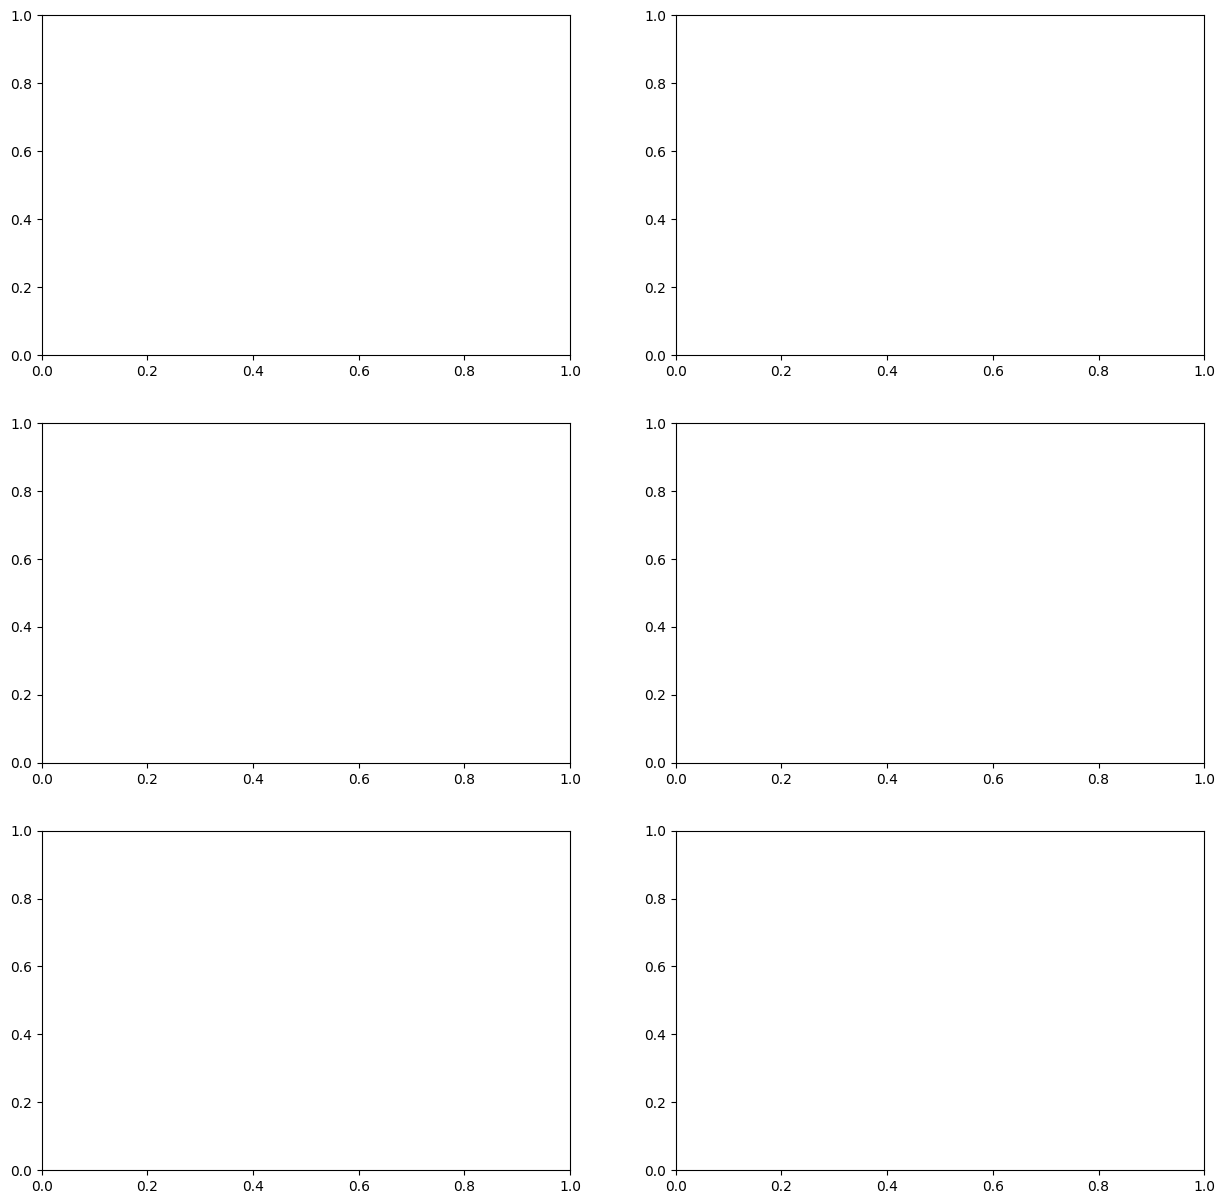

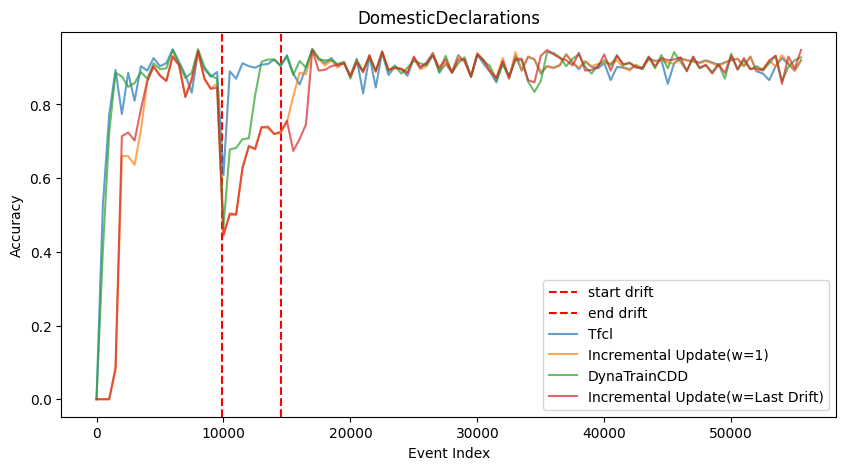

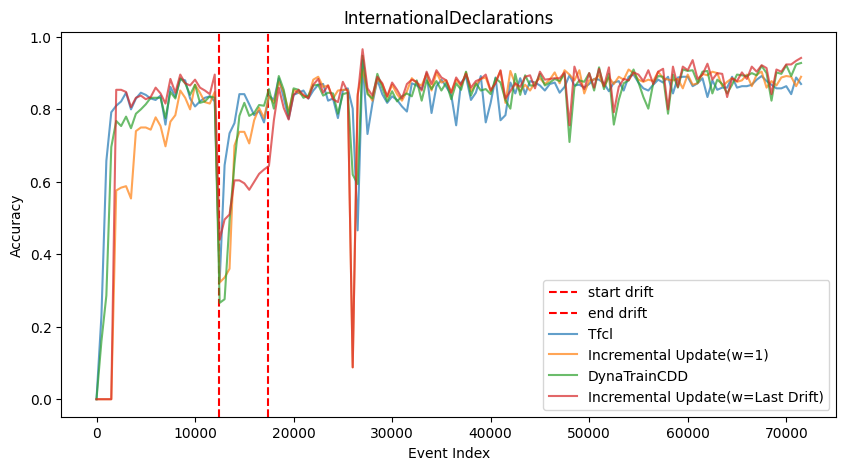

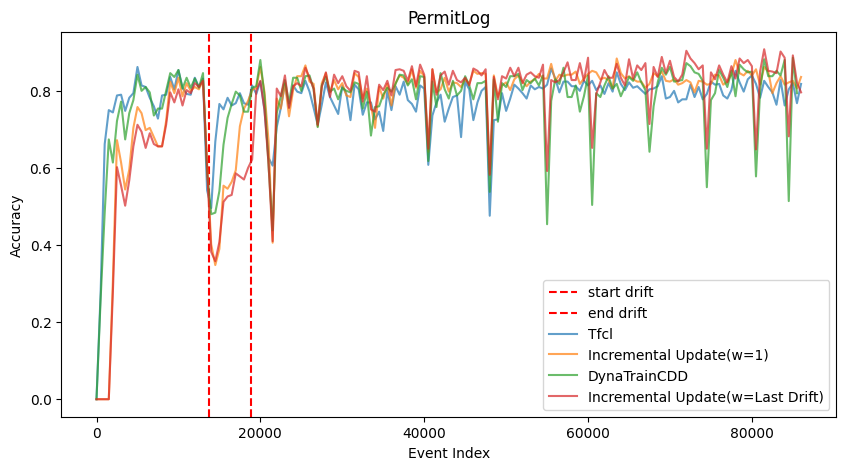

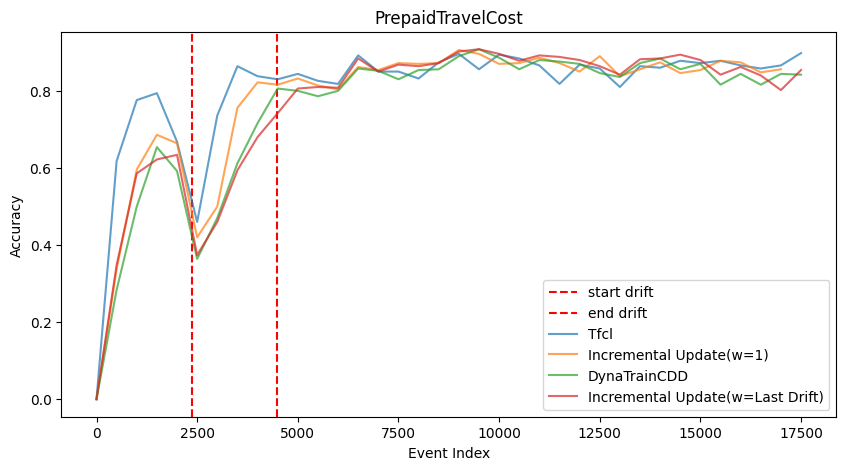

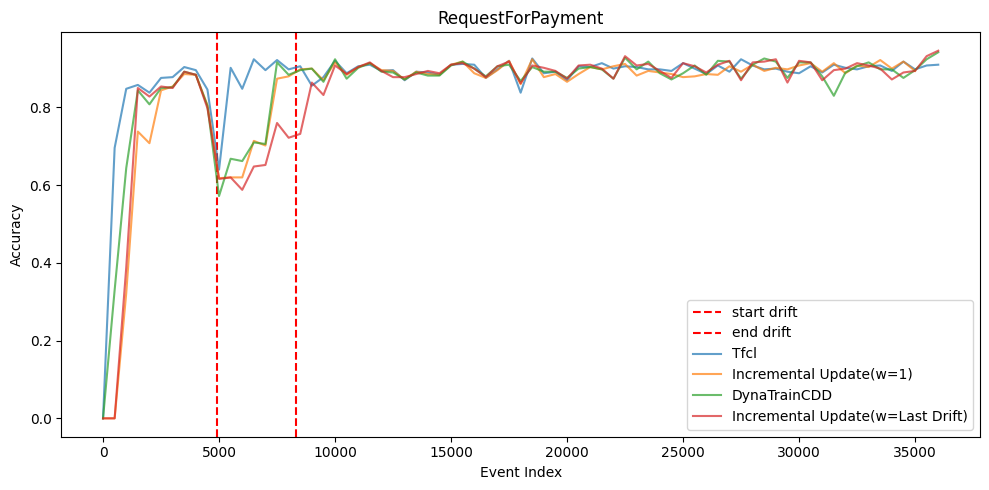

In [9]:
import os
# List of root folders
batch_size = 500
root_folders = ['/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results','/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results']  # Replace with your root directory path
root_folders = {
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_BPIC2020_ratio0': 'Tfcl',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_BPIC2020_ratio0': 'Incremental Update(w=1)',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_dycdd/results_BPIC2020_ratio0': 'DynaTrainCDD',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results_BPIC2020_ratio0':'Incremental Update(w=Last Drift)'
}

data_values = {}

# Iterate over root folders
for root_folder, display_name in root_folders.items():
    # Get list of sub-folders (individual experiments) in the current root folder
    experiment_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    
    # Iterate over each experiment folder
    for experiment in experiment_folders:
        experiment_path = os.path.join(root_folder, experiment)
        dataset_name = experiment_path.split("/")[-1].split("_")[0]
        first_drift = get_first_drift_realdata(dataset_name)[0]
        
        dataset_name, ratio, total_accuracy, total_accuracy_after_first_drift, running_time = get_dataset_name_and_ratio_and_accuracy_and_runningtime(experiment_path, first_drift)
        
        batch_accuracy = compute_batch_fixed_size_accuracy(pd.read_csv(os.path.join(root_folder, experiment, 'prediction_results.csv')), batch_size)
        
        # Store in dictionary
        key = f"{dataset_name}_{ratio}"
        if key not in data_values:
            data_values[key] = {}
        data_values[key][display_name] = (batch_accuracy, total_accuracy, running_time)

# Create a large figure with subplots
total_experiments = len(data_values)
cols = 2
rows = (total_experiments // cols) + (total_experiments % cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Order data_values by dataset_name and ratio for plotting
sorted_keys = sorted(data_values.keys(), key=lambda x: (x.split('_')[0], float(x.split('_')[1])))

# i=0
# # Plotting
# for idx, key in enumerate(sorted_keys):
    
#     start_drift, end_drift, old_concept_show_again = get_first_drift_realdata(key.split('_')[0])
#     ax = axes[idx // cols, idx % cols]
#     values = data_values[key]

#     # Plot the start_drift and end_drift lines once and label them
#     ax.axvline(x=start_drift, color='r', linestyle='--', label='start drift')
#     ax.axvline(x=end_drift, color='r', linestyle='--', label='end drift')

#     for method, (accuracy, total_accuracy, running_time) in values.items():
#         x_values = [x * batch_size for x in range(len(accuracy))]
#         # ax.plot(x_values, accuracy, label=f"{method} (Accuracy: {total_accuracy:.4f}, Running Time: {running_time:.2f}s)")
#         ax.plot(x_values, accuracy, label=f"{method}")


#     ax.set_title(key.split('_')[0])
#     ax.set_xlabel('Event Index')
#     ax.set_ylabel('Accuracy')
#     ax.legend()
#     i+=1
#     if i>=1:
#         break

i=0
# Plotting
for idx, key in enumerate(sorted_keys):
    if i>=0:
        start_drift, end_drift, old_concept_show_again = get_first_drift_realdata(key.split('_')[0])
        # ax = axes[idx // cols, idx % cols]
        values = data_values[key]
        plt.figure(figsize=(10,5))
        # Plot the start_drift and end_drift lines once and label them
        plt.axvline(x=start_drift, color='r', linestyle='--', label='start drift')
        plt.axvline(x=end_drift, color='r', linestyle='--', label='end drift')

        for method, (accuracy, total_accuracy, running_time) in values.items():
            x_values = [x * batch_size for x in range(len(accuracy))]
            # ax.plot(x_values, accuracy, label=f"{method} (Accuracy: {total_accuracy:.4f}, Running Time: {running_time:.2f}s)")
            plt.plot(x_values, accuracy, label=f"{method}", alpha=0.7)


        plt.title(key.split('_')[0])
        plt.xlabel('Event Index')
        plt.ylabel('Accuracy')
        plt.legend()
    i+=1
    # plt.clear()
    # if i>=1:
    #     break

plt.tight_layout()
plt.show()




### compare hyperparameter

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

root_folders = {
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results': '750',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_BPIC2020_ratio0': '500'
    # '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_rb500_hb200_mas0.5': '200',
    # '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_rb500_hb300_mas0.5': '300'
    # '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_rb750_hb100': 'rb750'
    #'/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results':'after_drift'
}
dataset_folder = '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/Data/synthetic_dataset'

# Store accuracy values
data_values = {}
hb_values = []
batch_size = 500

# Iterate over root folders
for root_folder, display_name in root_folders.items():
    hb_values.append(display_name)  # Store hyperparameter (hb) values
    # Get list of sub-folders (individual experiments) in the current root folder
    experiment_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    
    # Iterate over each experiment folder
    for experiment in experiment_folders:
        experiment_path = os.path.join(root_folder, experiment)
        dataset_name, ratio, total_accuracy, total_accuracy_after_first_drift = get_dataset_name_and_ratio_and_accuracy(experiment_path,1)

        # Store in dictionary
        key = dataset_name
        if key not in data_values:
            data_values[key] = []
        data_values[key].append(total_accuracy)  # Store total accuracy for the corresponding hb value

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data_values, index=hb_values)
# Convert to DataFrame for easier plotting
df = pd.DataFrame(data_values, index=hb_values)
print(df)

# Find the hyperparameter that achieved the highest accuracy for each dataset
best_hyperparameters = df.idxmax()

# Count how many times each hyperparameter was the best
best_hyperparameter_counts = best_hyperparameters.value_counts()

print(best_hyperparameter_counts)

# Find the hyperparameter that was best most often
best_hyperparameter = best_hyperparameter_counts.idxmax()

# Compute the difference between the best hyperparameter and others for each dataset
difference_from_best = df.loc[best_hyperparameter] - df.drop(index=best_hyperparameter).max()

print(f"The best hyperparameter (number of hard samples) is {best_hyperparameter}.")
print("\nDifference in accuracy compared to the next best hyperparameter for each dataset:")
print(difference_from_best)

# Compute the percentage difference between the best hyperparameter and others for each dataset
percentage_difference_from_best = (difference_from_best / df.drop(index=best_hyperparameter).max()) * 100
# print("\nPercentage increase in accuracy compared to the next best hyperparameter for each dataset:")
# print(percentage_difference_from_best)

print("\nPercentage increase in accuracy compared to the next best hyperparameter for each dataset:")
for dataset, percentage in percentage_difference_from_best.items():
    print(f"{dataset}: {100*percentage:.2f}%")

# Find the minimum and maximum accuracy values
min_accuracy = df.min().min()
max_accuracy = df.max().max()

# Create a bar plot
ax = df.T.plot(kind='bar', figsize=(15, 8))
plt.title("Comparison of Model Accuracy for Different Hyperparameters (number of hard samples)")
plt.ylabel("Accuracy")
plt.xlabel("Datasets")
plt.ylim(min_accuracy - 0.01, max_accuracy + 0.01)
plt.xticks(rotation=45)
plt.legend(title="Hyperparameters (number of hard samples)")
plt.tight_layout()
plt.show()


NameError: name 'get_dataset_name_and_ratio_and_accuracy' is not defined

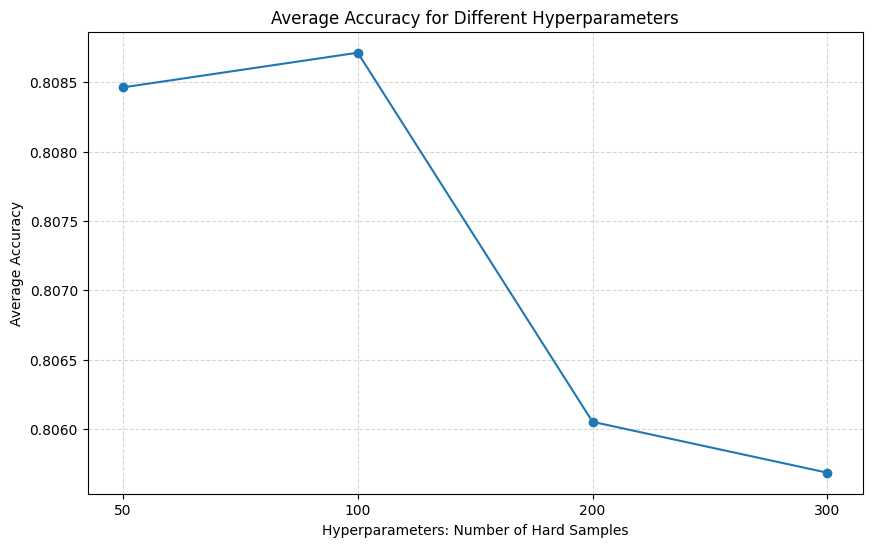

In [ ]:
# df = pd.DataFrame(data, index=[0.1, 0.5, 1, 1.5])

# Calculate the average accuracy for each hyperparameter
average_accuracy = df.mean(axis=1)

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(average_accuracy, marker='o')
plt.title("Average Accuracy for Different Hyperparameters")
plt.xlabel("Hyperparameters: Number of Hard Samples")
plt.ylabel("Average Accuracy")
plt.xticks(average_accuracy.index)  # Set x-ticks to be the hyperparameter values
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

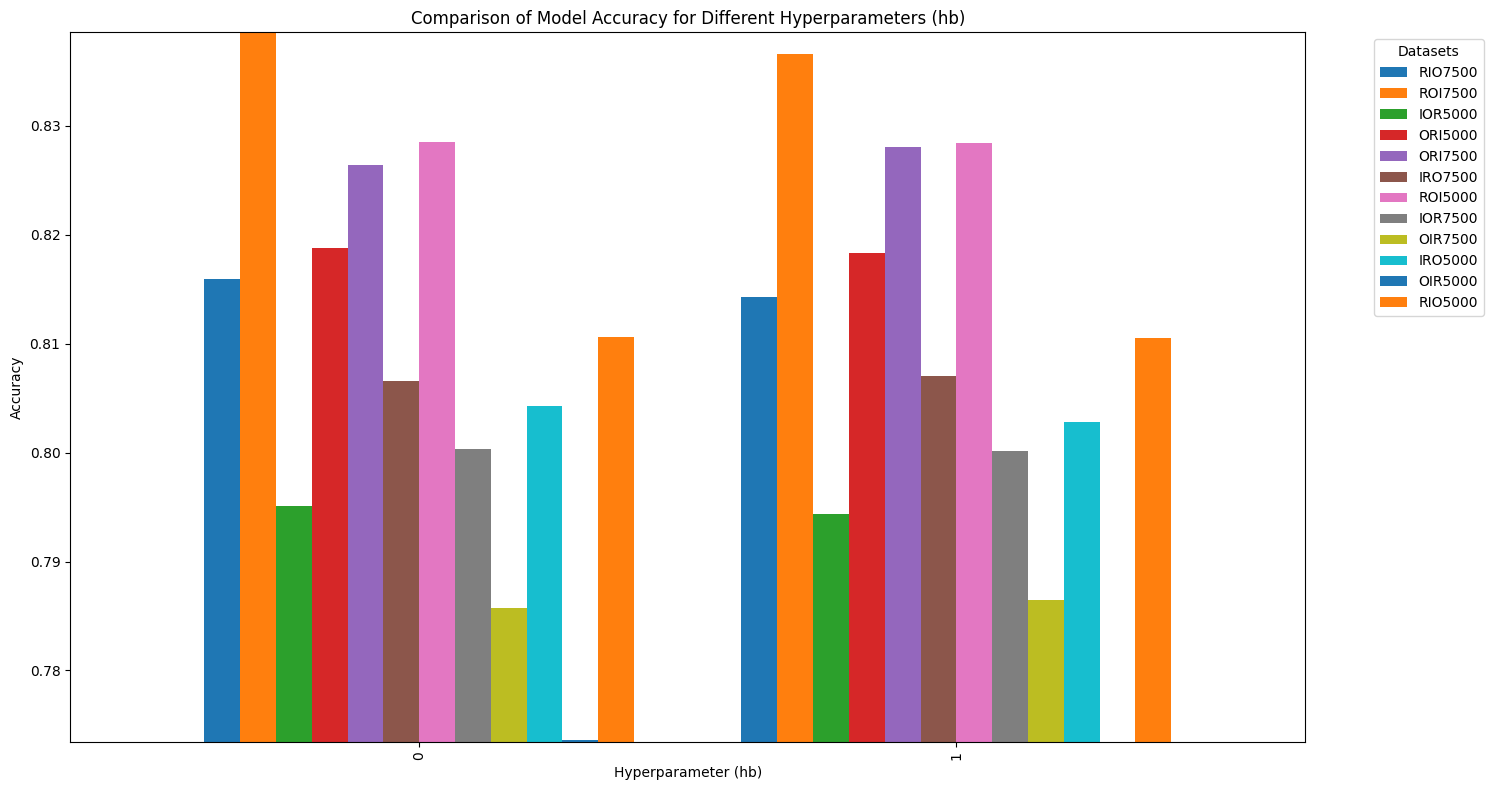

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data_values dictionary has been populated as per your code

# Convert the data_values to a DataFrame
df = pd.DataFrame(data_values)

# Find the minimum and maximum accuracy values for y-axis limits
min_accuracy = df.values.min()
max_accuracy = df.values.max()

# Create a bar plot with hb values on x-axis and datasets as individual bars within each hb cluster
ax = df.plot(kind='bar', figsize=(15, 8), width=0.8)

plt.title("Comparison of Model Accuracy for Different Hyperparameters (hb)")
plt.ylabel("Accuracy")
plt.xlabel("Hyperparameter (hb)")
plt.ylim(min_accuracy, max_accuracy)  # Set y-axis limits
plt.legend(title="Datasets", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### visual synthetitic data results

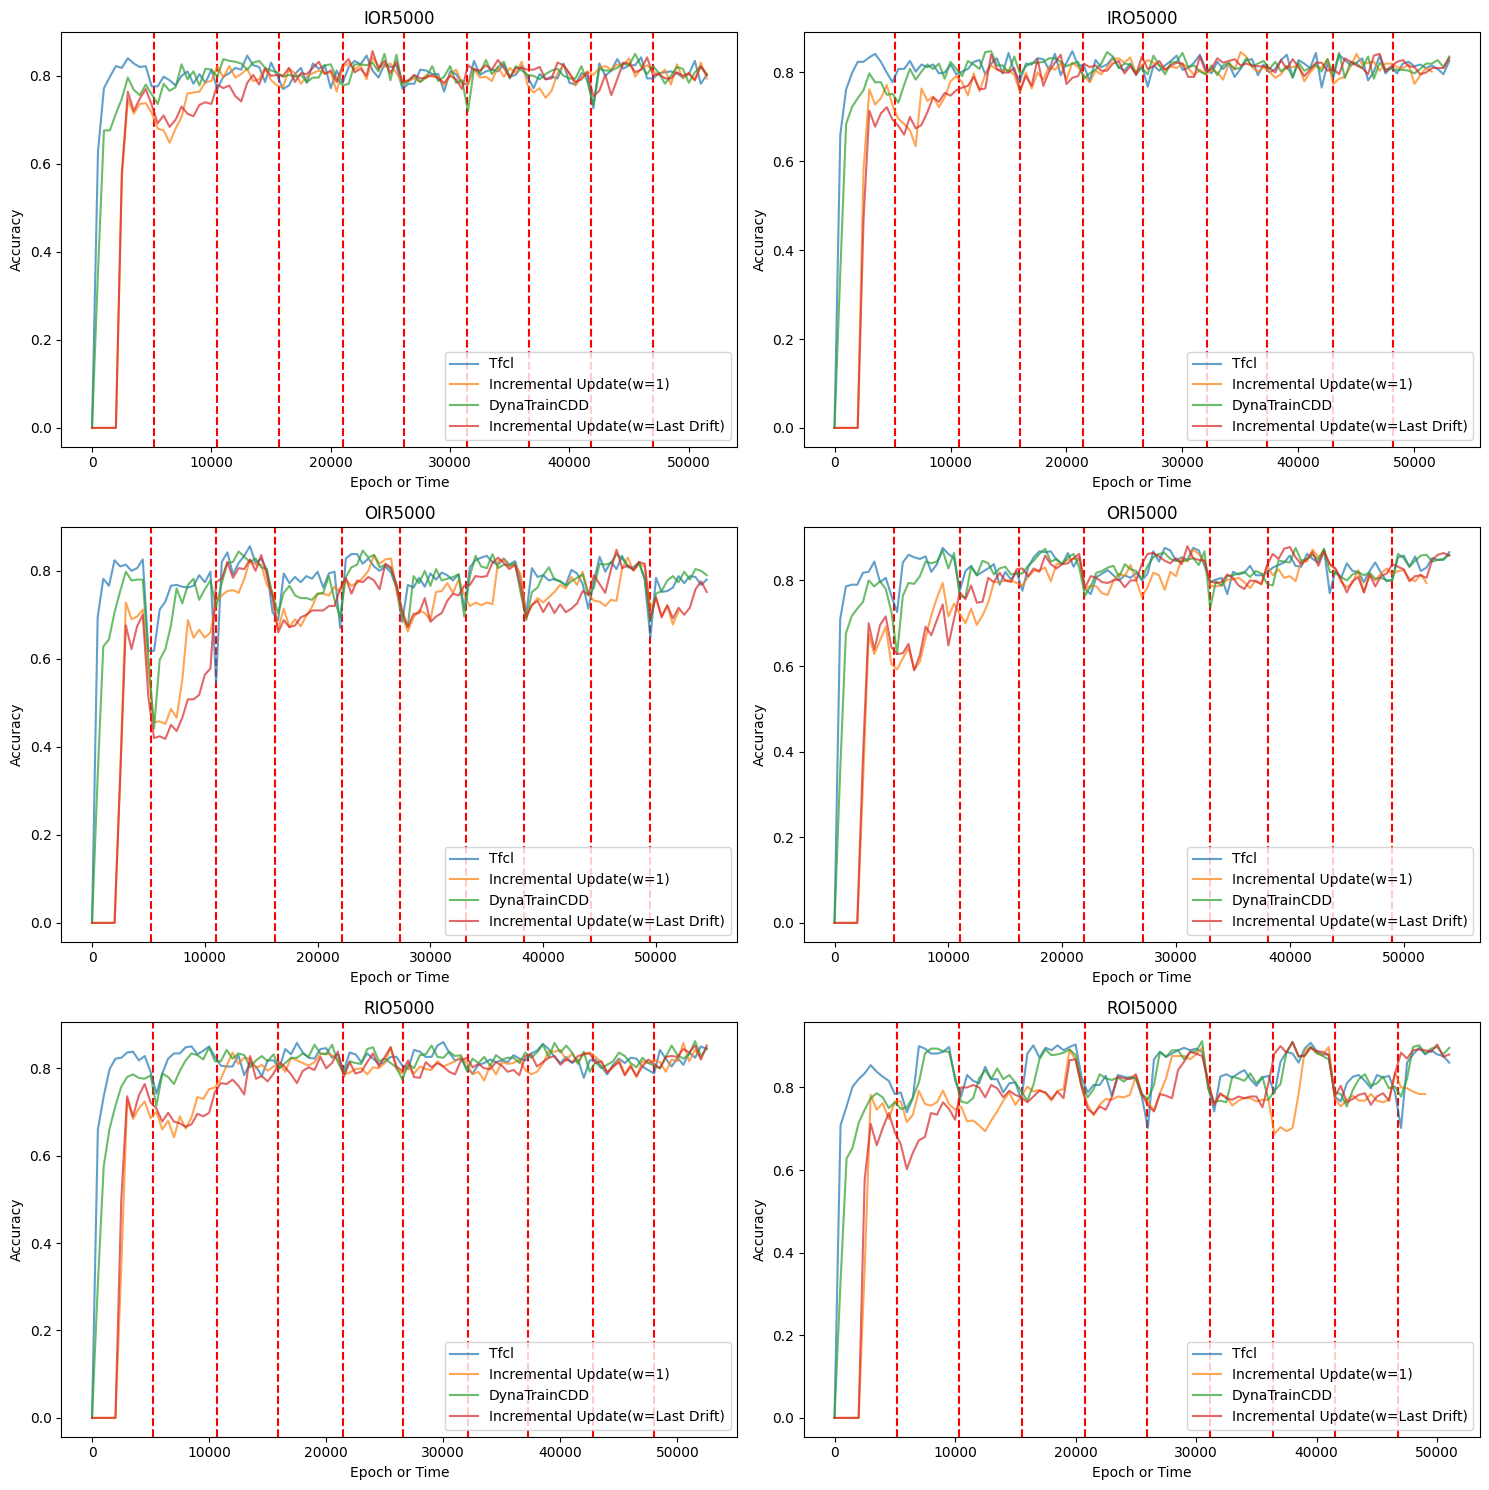

In [13]:
import os

root_folders = {
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_syntheticdata': 'Tfcl',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_syntheticdata': 'Incremental Update(w=1)',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_dycdd/results_syntheticdata': 'DynaTrainCDD',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results_syntheticdata': 'Incremental Update(w=Last Drift)'
    #'/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results':'after_drift'
}
# Store accuracy values

data_values = {}
dataset_folder = '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/Data/synthetic_dataset'
batch_size = 500

# Iterate over root folders
for root_folder, display_name in root_folders.items():
    experiment_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    
    for experiment in experiment_folders:
        experiment_path = os.path.join(root_folder, experiment)
        dataset_name = experiment_path.split("/")[-1].split("_")[0]
        dataset_path = os.path.join(dataset_folder, dataset_name+'.csv')
        _, drift_locations = get_drift_locations(dataset_path)
        
        dataset_name, ratio, total_accuracy, total_accuracy_after_first_drift, running_time = get_dataset_name_and_ratio_and_accuracy_and_runningtime(experiment_path, drift_locations[0])
        
        batch_accuracy = compute_batch_fixed_size_accuracy(pd.read_csv(os.path.join(root_folder, experiment, 'prediction_results.csv')), batch_size)
        
        key = f"{dataset_name}_{ratio}"
        if key not in data_values:
            data_values[key] = {}
        data_values[key][display_name] = (batch_accuracy, total_accuracy, running_time)  # Store running_time as well

# Create a large figure with subplots
total_experiments = len(data_values)
cols = 2
rows = (total_experiments // cols) + (total_experiments % cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

sorted_keys = sorted(data_values.keys(), key=lambda x: (x.split('_')[0], float(x.split('_')[1])))

# Plotting
for idx, key in enumerate(sorted_keys):
    ax = axes[idx // cols, idx % cols]
    values = data_values[key]
    dataset_path = os.path.join(dataset_folder, key.split('_')[0]+'.csv')
    _, drift_locations = get_drift_locations(dataset_path)
    drift_locations = drift_locations[:-1]
    for drift_location in drift_locations:
        ax.axvline(x=drift_location, color='red', linestyle='--')
    for method, (accuracy, total_accuracy, running_time) in values.items():  # Unpack running_time here
        x_values = [x * 500 for x in range(len(accuracy))]
        # ax.plot(x_values, accuracy, label=f"{method} (Accuracy: {total_accuracy:.4f}, Running Time: {running_time:.2f}s)")
        ax.plot(x_values, accuracy, label=f"{method}", alpha=0.7)

    ax.set_title(key.split('_')[0])
    ax.set_xlabel('Epoch or Time')
    ax.set_ylabel('Accuracy')
    ax.legend()

plt.tight_layout()
plt.show()

# i=0
# # Plotting
# for idx, key in enumerate(sorted_keys):
#     if i>=0:
#         start_drift, end_drift, old_concept_show_again = get_first_drift_realdata(key.split('_')[0])
#         # ax = axes[idx // cols, idx % cols]
#         values = data_values[key]
#         plt.figure(figsize=(10,5))
#         # Plot the start_drift and end_drift lines once and label them
#         plt.axvline(x=start_drift, color='r', linestyle='--', label='start drift')
#         plt.axvline(x=end_drift, color='r', linestyle='--', label='end drift')

#         for method, (accuracy, total_accuracy, running_time) in values.items():
#             x_values = [x * batch_size for x in range(len(accuracy))]
#             # ax.plot(x_values, accuracy, label=f"{method} (Accuracy: {total_accuracy:.4f}, Running Time: {running_time:.2f}s)")
#             plt.plot(x_values, accuracy, label=f"{method}", alpha=0.7)


#         plt.title(key.split('_')[0])
#         plt.xlabel('Event Index')
#         plt.ylabel('Accuracy')
#         plt.legend()
#     i+=1
#     # plt.clear()
#     # if i>=1:
#     #     break

# plt.tight_layout()
# plt.show()

In [ ]:
dataset_path = os.path.join(dataset_folder, dataset_name+'.csv')
print(dataset_path)

/Users/meruozhu/Downloads/MP_data/MP_codes/MP/Data/synthetic_dataset/IOR5000.csv


### visual sudden drift results

In [21]:
def get_drift_locations_suddendrift(dataName):
    if dataName == "BPIC15ALL":
        drift_locations = [52217, 96571, 156252,203545]
    elif dataName == 'BPIC17':
        drift_locations = []
    elif dataName == 'Hospital+BPI12':
        drift_locations = [16000, 275000]
    return drift_locations

In [22]:
root_folders = {
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_suddendrift': 'Tfcl',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_suddendrift': 'Incremental Update(w=1)',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_dycdd/results_suddendrift': 'DynaTrainCDD',
    '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results_sudden_drift':'Incremental Update(w=Last Drift)'
}
print(root_folders.items())

dict_items([('/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_suddendrift', 'Tfcl'), ('/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_suddendrift', 'Incremental Update(w=1)'), ('/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_dycdd/results_suddendrift', 'DynaTrainCDD'), ('/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results_sudden_drift', 'Incremental Update(w=Last Drift)')])


/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_suddendrift Tfcl
Content of /Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_suddendrift (Tfcl): ['Hospital+BPI12_new_rbs1000_hbs200_2023-09-04_00-03-10', 'BPIC15ALL_rbs500_hbs100_2023-09-05_13-09-18', 'BPIC17_rbs500_hbs100_2023-08-31_16-47-45']
/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_suddendrift Incremental Update(w=1)
Content of /Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_suddendrift (Incremental Update(w=1)): ['BPIC15ALL_rbs4451_hbs0_2023-08-30_15-17-29', 'Hospital+BPI12_new_rbs10576_hbs0_2023-09-02_11-22-48', 'BPIC17_rbs25000_hbs0_2023-08-31_17-21-31']
/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_dycdd/results_suddendrift DynaTrainCDD
Content of /Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_dycdd/results_sudden

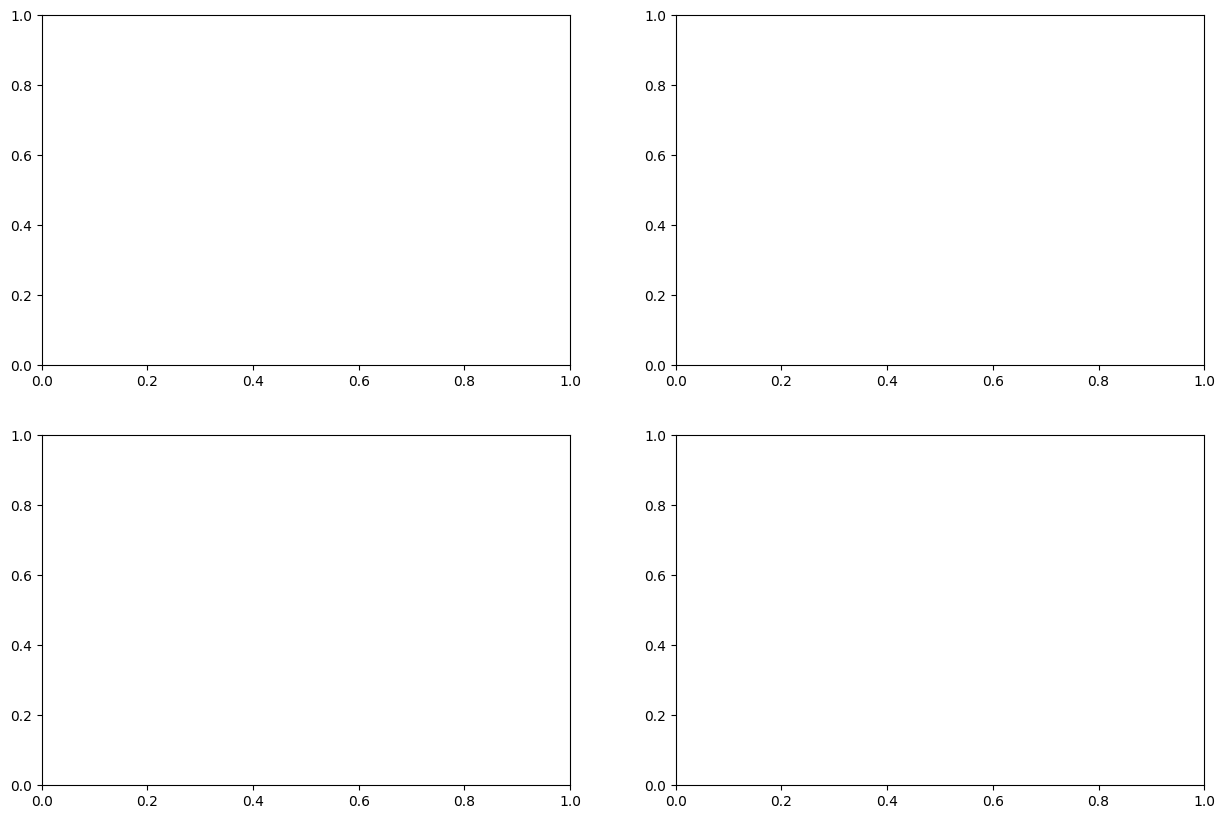

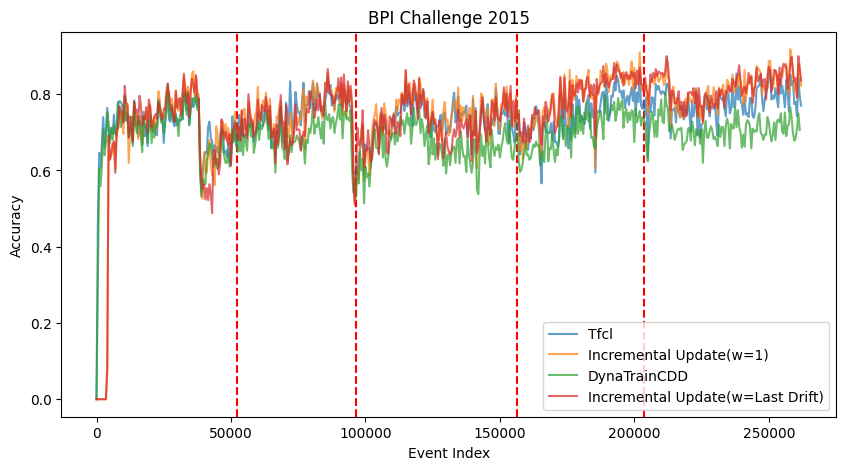

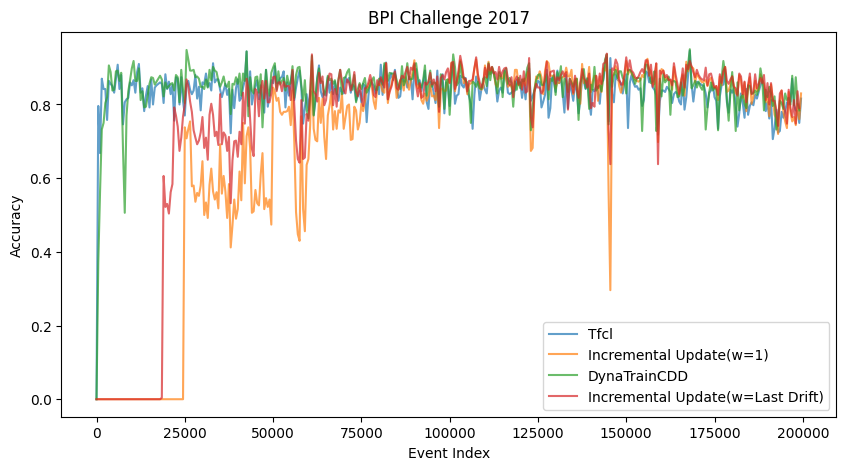

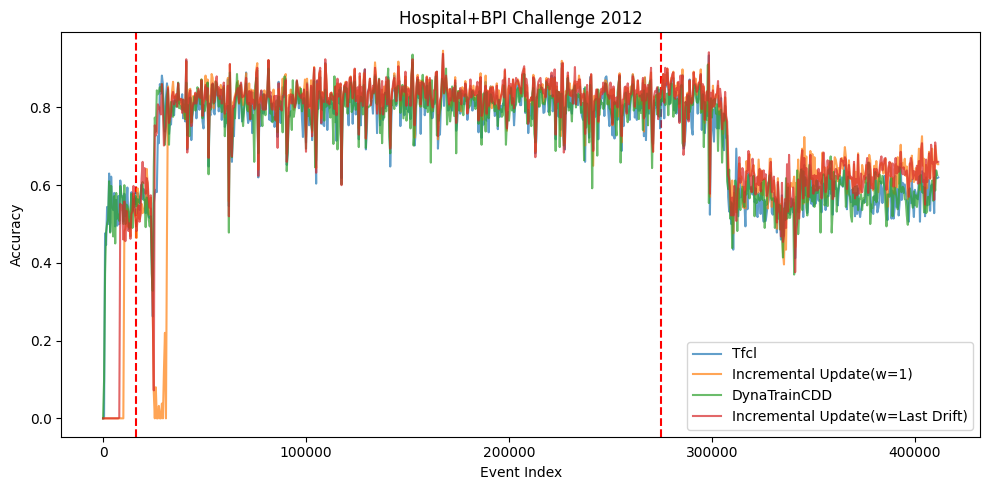

y


In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

batch_size = 500

# Define the root folders for each method
# root_folders = {
#     '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_suddendrift': 'tfcl',
#     '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_update/results_suddendrift': 'monthly_update',
#     '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_tfcl_sdl/results_suddendrift': 'dycdd',
#     '/Users/meruozhu/Downloads/MP_data/MP_codes/MP/experiments/experiments_sdl_drift/results_sudden_drift':'after_drift'
# }

data_values = {}

# Iterate over root folders
for root_folder, display_name in root_folders.items():
    print(root_folder, display_name)
    experiment_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    
    # Debug print to check the content of the directory
    print(f"Content of {root_folder} ({display_name}): {experiment_folders}")
    
    for experiment in experiment_folders:
        experiment_path = os.path.join(root_folder, experiment)
        dataset_name, ratio, total_accuracy, total_accuracy_after_first_drift, running_time = get_dataset_name_and_ratio_and_accuracy_and_runningtime(experiment_path)
        
        batch_accuracy = compute_batch_fixed_size_accuracy(pd.read_csv(os.path.join(root_folder, experiment, 'prediction_results.csv')), batch_size)
        
        key = f"{dataset_name}_{ratio}"
        if key not in data_values:
            data_values[key] = {}
        data_values[key][display_name] = (batch_accuracy, total_accuracy, running_time)

        # Debug print to check the processed data for "tfcl"
        if display_name == "tfcl":
            print(f"Data for {display_name} in {experiment}: {data_values[key][display_name]}")

# ... [rest of the code remains unchanged]
# Run the modified code and check the debug prints. This will help identify where the issue might be occurring. If the data for "tfcl" is correctly loaded and processed, it should appear in the figures. If not, the debug prints will provide clues about where the problem might be.




# Create a large figure with subplots
total_experiments = len(data_values)
cols = 2
rows = (total_experiments // cols) + (total_experiments % cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

sorted_keys = sorted(data_values.keys(), key=lambda x: (x.split('_')[0], float(x.split('_')[1])))

# Plotting
# for idx, key in enumerate(sorted_keys):
#     ax = axes[idx // cols, idx % cols]
#     values = data_values[key]

#     drift_locations = get_drift_locations_suddendrift(dataName=key.split('_')[0])
#     for drift_location in drift_locations:
#         ax.axvline(x=drift_location, color='red', linestyle='--')

#     for method, (accuracy, total_accuracy, running_time) in values.items():
#         x_values = [x * batch_size for x in range(len(accuracy))]
#         # ax.plot(x_values, accuracy, label=f"{method} (accuracy: {total_accuracy:.4f}, running_time: {running_time:.2f}s)")
#         ax.plot(x_values, accuracy, label=f"{method}",alpha=0.7)

#     ax.set_title(key.split('_')[0])
#     ax.set_xlabel('Event Index')
#     ax.set_ylabel('Accuracy')
#     ax.legend()

# plt.tight_layout()
# plt.show()

for idx, key in enumerate(sorted_keys):
    # ax = axes[idx // cols, idx % cols]
    values = data_values[key]
    plt.figure(figsize=(10,5))
    drift_locations = get_drift_locations_suddendrift(dataName=key.split('_')[0])
    print(drift_locations)
    for drift_location in drift_locations:
        plt.axvline(x=drift_location, color='red', linestyle='--')

    for method, (accuracy, total_accuracy, running_time) in values.items():
        x_values = [x * batch_size for x in range(len(accuracy))]
        # ax.plot(x_values, accuracy, label=f"{method} (accuracy: {total_accuracy:.4f}, running_time: {running_time:.2f}s)")
        plt.plot(x_values, accuracy, label=f"{method}",alpha=0.7)
    if key.split('_')[0]=='BPIC15ALL':
        title = 'BPI Challenge 2015'
    elif key.split('_')[0]=='BPIC17':
        title = 'BPI Challenge 2017'
    elif key.split('_')[0]=='Hospital+BPI12':
        title = 'Hospital+BPI Challenge 2012'
    plt.title(title)
    plt.xlabel('Event Index')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

print('y')